# Cell segmentation

This tutorial will showcase the cell segmentation methods provided with Spateo.

When using high-resolution spatial transcriptomics assays, such as BGI's Stereo-seq, each cell is captured by many pixels (approximately 400 for Stereo-seq). This allows us to aggregate UMIs from neighboring pixels to perform single-cell segmentation, ultimately yielding a (segmented) cell x gene count matrix just like single-cell RNA-seq (scRNA-seq) assays. As a result, many of the tools and approaches developed for scRNA-seq can be applied with ease, with the added benefits of having spatial information.

<br>

**Table of contents**

[1. Load the data](#1.-Load-the-data)

[2. Nuclei-staining segmentation](#2.-Nuclei-staining-segmentation) (used if a staining image is available)

[3. RNA-only segmentation](#3.-RNA-only-segmentation) (used if a staining image is not available)

[4. Getting a cell x gene matrix](#4.-Getting-a-cell-x-gene-matrix)

In [1]:
import spateo as st
import matplotlib.pyplot as plt

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
parallel.py (366): The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shape

## 1. Load the data

We will be using a truncated mouse coronal section dataset from [Chen et al., 2021](https://doi.org/10.1101/2021.01.17.427004).

In [6]:
!wget "https://drive.google.com/uc?export=download&id=1nONOaUy7utvtXQ3ZPx7R3TePq2Oo4JFM" -O SS200000135IL-D1.ssDNA.tif
!wget "https://drive.google.com/uc?export=download&id=18sM-5LmxOgt-3kq4ljtq_EdWHjihvPUx" -O SS200000135TL_D1_all_bin1.txt.gz

--2022-04-06 16:22:05--  https://drive.google.com/uc?export=download&id=1nONOaUy7utvtXQ3ZPx7R3TePq2Oo4JFM
Resolving drive.google.com (drive.google.com)... 172.217.165.142
Connecting to drive.google.com (drive.google.com)|172.217.165.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tbm86m9e9ukr4p1u3ari8t2qa1e7eeou/1649276475000/01008102307516202257/*/1nONOaUy7utvtXQ3ZPx7R3TePq2Oo4JFM?e=download [following]
--2022-04-06 16:22:06--  https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tbm86m9e9ukr4p1u3ari8t2qa1e7eeou/1649276475000/01008102307516202257/*/1nONOaUy7utvtXQ3ZPx7R3TePq2Oo4JFM?e=download
Resolving doc-0g-1g-docs.googleusercontent.com (doc-0g-1g-docs.googleusercontent.com)... 142.250.72.97
Connecting to doc-0g-1g-docs.googleusercontent.com (doc-0g-1g-docs.googleusercontent.com)|142.250.72.97|:443... connected.
HTT

Load the downloaded UMI counts and nuclei staining image into an AnnData object. For the purposes of cell segmentation, we will be working with an aggregated counts matrix, where the `obs` and `var` of the AnnData correspond to the spatial X and Y coordinates, and each element of the matrix contains the total number of UMIs captured for each X and Y coordinate.

In [24]:
adata = st.io.read_bgi_agg(
    'SS200000135TL_D1_all_bin1.txt.gz',
    'SS200000135IL-D1.ssDNA.tif',
    scale=0.5, scale_unit='um',  # specifies the physical units of each coordinate
                                 # for plotting purposes
    gene_agg={'nuclear': ['Malat1']}  # Add a layer for nuclear-localized genes
)
adata

|-----? Padding stain image from (2000, 2000) to (2001, 2001) with zeros.
|-----> Constructing count matrices.
|-----> Aggregating counts for genes provided by `gene_agg`.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2001 × 2001
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced', 'nuclear'

|-----> <select> stain layer in AnnData Object


(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'stain'}, xlabel='um', ylabel='um'>)

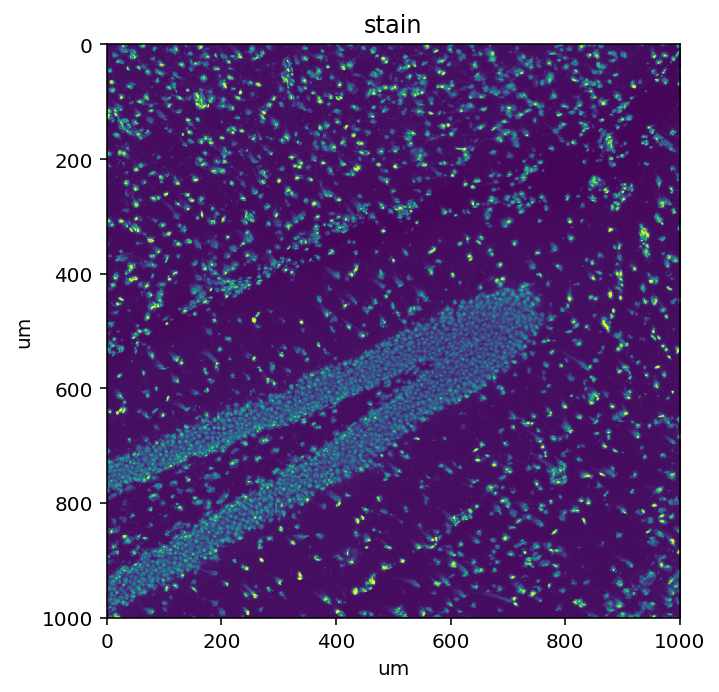

In [4]:
st.pl.imshow(adata, 'stain')

## 2. Nuclei-staining segmentation

In this section, we assume you have the nuclei staining image (of the same slice) available. We will use the nuclei staining as the ground-truth location of the nuclei and use this information to obtain cell segmentation. We will do so in the following steps.

0. As a pre-processing step, we will refine the alignment between the staining image and the RNA coordinates.
1. Identify and label individual nuclei using a [Watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing))-based approach.
2. Do the same using a deep-learning-based approach called [StarDist](https://github.com/stardist/stardist).
3. Augment the StarDist labels using the Watershed labels by copying over labels that are present in the Watershed approach but do not overlap with any labels in the StarDist approach.
4. [Optional] Expand the nuclei labels to cytoplasm.

We will see why Step 3 is important.

### 2.0. Refine alignment

The staining image should already be roughly aligned with the RNA coordinates, but there may be minor misalignments. Large misalignments can lead to incorrect UMI aggregation (and thus incorrect cells!). Therefore, we believe it is good practice to refine the alignment provided directly from the spatial transcriptomics assay.

Spateo provides two alignment strategies, but here we will be using the simpler `rigid` alignment because testing showed this to perform well for this sample. For other samples, the `non-rigid` alignment method may perform better.

**TODO: add link to technical details page in documentation**

In [31]:
before = adata.layers['stain'].copy()
st.pp.segmentation.refine_alignment(adata, mode='rigid', transform_layers=['stain'])

|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> Refining alignment in rigid mode.


Loss -4.7398e-03: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


|-----> Transforming layers ['stain']
|-----> <select> stain layer in AnnData Object
|-----> <insert> stain to layers in AnnData Object.


|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object


Text(0.5, 1.0, 'after alignment')

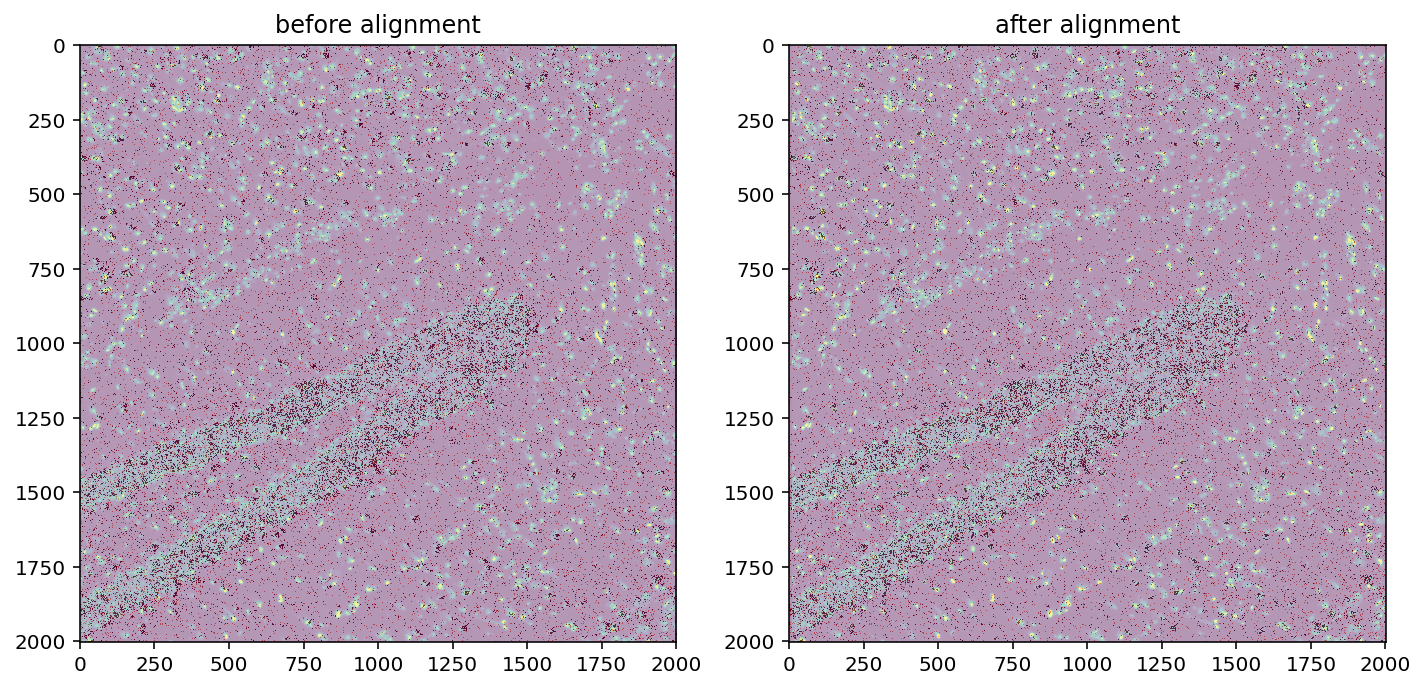

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
axes[0].imshow(before)
st.pl.imshow(adata, 'unspliced', ax=axes[0], alpha=0.6, cmap='Reds', vmax=2, use_scale=False)
axes[0].set_title('before alignment')
st.pl.imshow(adata, 'stain', ax=axes[1], use_scale=False)
st.pl.imshow(adata, 'unspliced', ax=axes[1], alpha=0.6, cmap='Reds', vmax=2, use_scale=False)
axes[1].set_title('after alignment')

We can observe that the alignment has visibly improved.

### 2.1. Watershed-based approach

Spateo includes a custom Watershed-based approach to segment and label nuclei from the staining image. At a high level, it uses a combination of global and local thresholding to first obtain a mask of nuclei, and then uses Watershed to assign labels.

**TODO: add link to technical details page in documentation**

In [160]:
st.pp.segmentation.mask_nuclei_from_stain(adata)
st.pp.segmentation.watershed_markers(adata)
st.pp.segmentation.watershed(adata, out_layer='watershed_labels')

|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object
|-----> Finding Watershed markers with iterative erosion.


Eroding: 11it [00:00, 50.98it/s]

|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.


|-----> <insert> watershed_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object


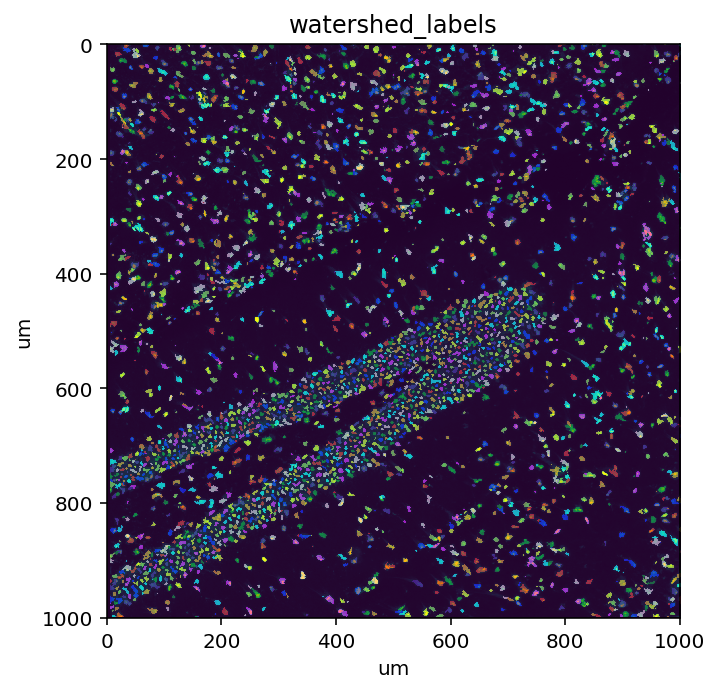

In [16]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'watershed_labels', labels=True, alpha=0.5, ax=ax)

## 2.2. Deep-learning-based approach

Spateo includes a variety of existing deep-learning approaches for fluroescent nuclei segmentation, such as StarDist, Cellpose and DeepCell. We've found StarDist to perform most consistenly the best among these methods, so that is what we will be using here.

<div class="alert alert-info">
Note
    
We are using `tilesize=-1` here to turn off tiling, since this is a small dataset. Usually, you can leave this to its default value.
    
</div>

In [161]:
st.pp.segmentation.stardist(adata, tilesize=-1, out_layer='stardist_labels')

|-----> <select> stain layer in AnnData Object
|-----> Equalizing image with CLAHE.
|-----> Running StarDist with model 2D_versatile_fluo.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
|-----> Fixing disconnected labels.
|-----> <insert> stardist_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object


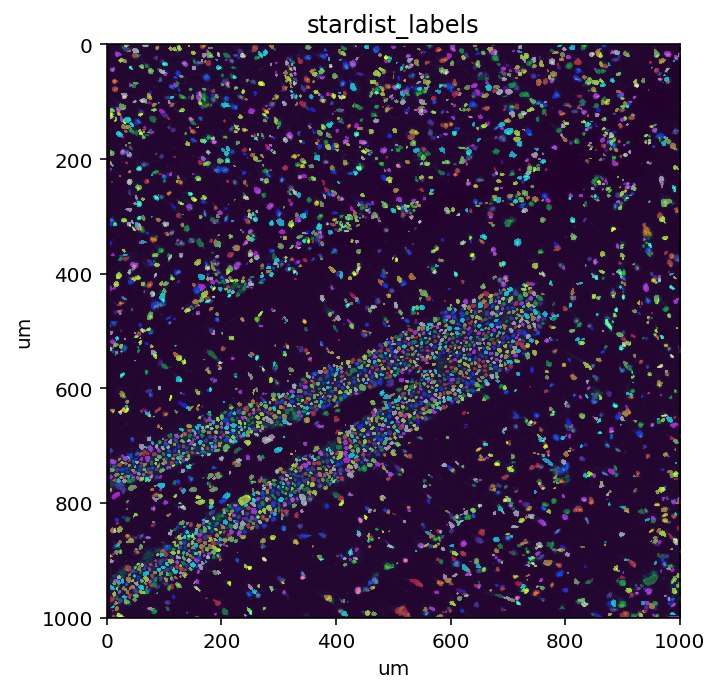

In [14]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'stardist_labels', labels=True, alpha=0.5, ax=ax)

## 2.3. Augment labels

Though both the Watershed and StarDist methods perform well in segmenting nuclei, they each have their limitations. The Watershed approach tends to result in rough cell boundaries do to the nature of thresholding, while StarDist sometimes has difficulty identifying nuclei in dense regions (resulting in "holes"). We can mitigate these by augmenting the StarDist labels with Watershed labels, copying over Watershed labels that do not overlap with any Stardist labels.

In [164]:
st.pp.segmentation.augment_labels(adata, 'watershed_labels', 'stardist_labels', out_layer='augmented_labels')

|-----> <select> watershed_labels layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object
|-----> <insert> augmented_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object


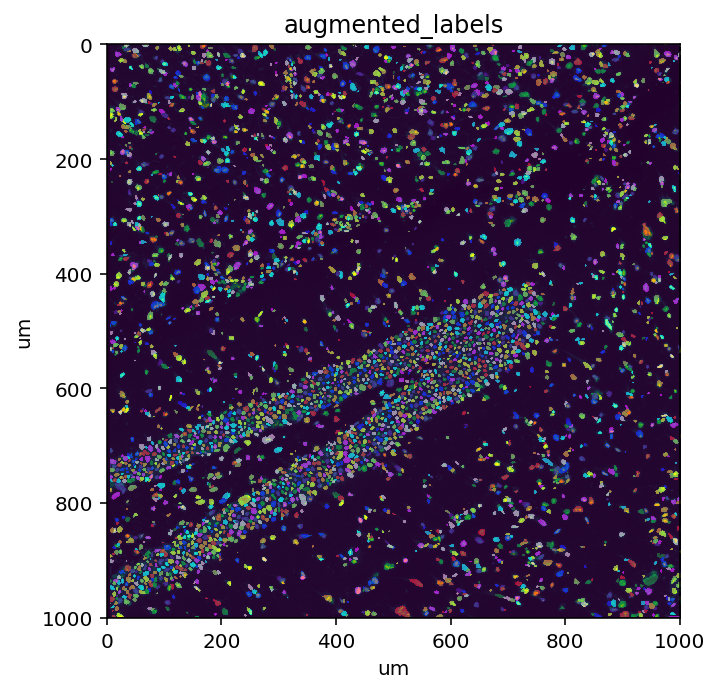

In [18]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'augmented_labels', labels=True, alpha=0.5, ax=ax)

## 2.4 Expand labels to cytoplasm

In the previous sections, we've identified and labeled individual nuclei from the staining image. It is possible to use these labels directly to obtain a cell x gene count matrix (it would actually be a nucleus x gene matrix), but this usually results in very few reads per observation. Therefore, we recommend converting the nuclei labels into cell labels by expanding the nuclei labels to include the cytoplasm.

To do so, we will take advantage of the fact that ssDNA staining weakly stains the cytoplasm, and thus we can identify cytoplasmic regions by thresholding the image with a lenient threshold.

In [165]:
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.pp.segmentation.watershed(
    adata, 'stain',
    mask_layer='stain_cell_mask',
    markers_layer='augmented_labels',
    out_layer='cell_labels',
)

|-----> <select> stain layer in AnnData Object
|-----> Constructing cell mask from staining image.
|-----> <insert> stain_cell_mask to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_cell_mask layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> cell_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels layer in AnnData Object


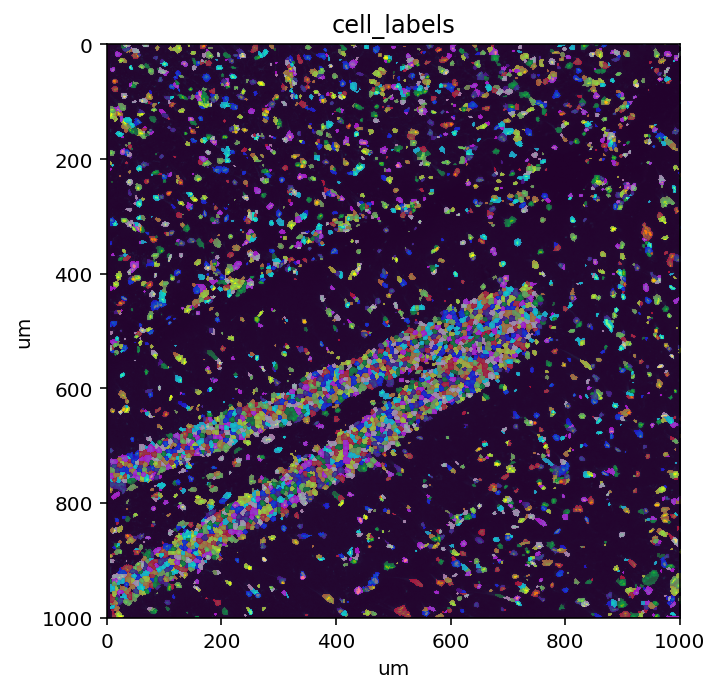

In [20]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'cell_labels', labels=True, alpha=0.5, ax=ax)

An alternative for labeling strategies that is highly specific to the nuclei is to simply expand each label by some distance.

In [21]:
st.pp.segmentation.expand_labels(adata, 'augmented_labels', distance=5, max_area=400)

|-----> <select> augmented_labels layer in AnnData Object
|-----> Expanding labels.
|-----> <insert> augmented_labels_expanded to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> augmented_labels_expanded layer in AnnData Object


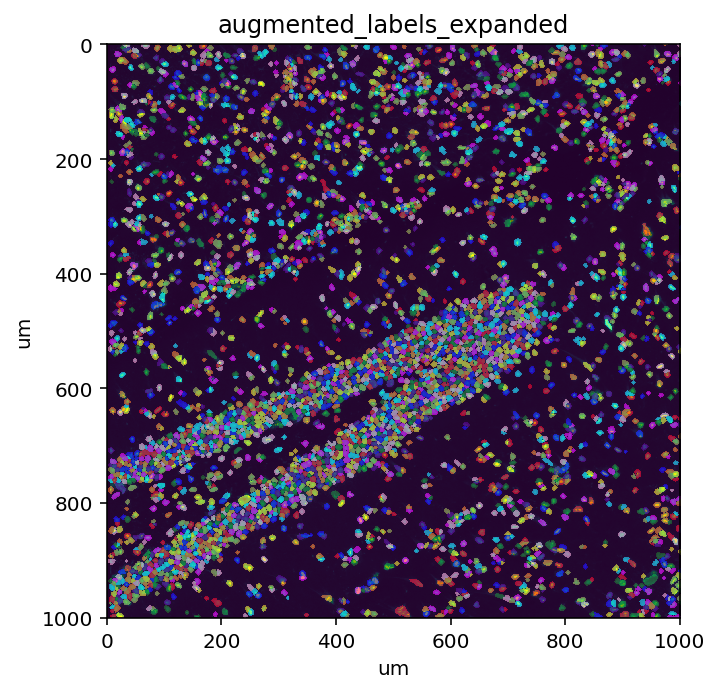

In [22]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'augmented_labels_expanded', labels=True, alpha=0.5, ax=ax)

## 3. RNA-only segmentation

In this section, we will showcase a novel method of achieving cell segmentation using RNA signal only (assuming we don't have the nuclei staining image). This is done in the following steps.

1. Identify nuclei using nuclear-localized genes (in our case, we'll use the `Malat1` gene).
2. Identify additional nuclei using unspliced RNA.
3. [Optional] Expand the nuclei labels to cytoplasm.

**TODO: add link to technical details page in documentation**

|-----> <select> nuclear layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> <select> X layer in AnnData Object


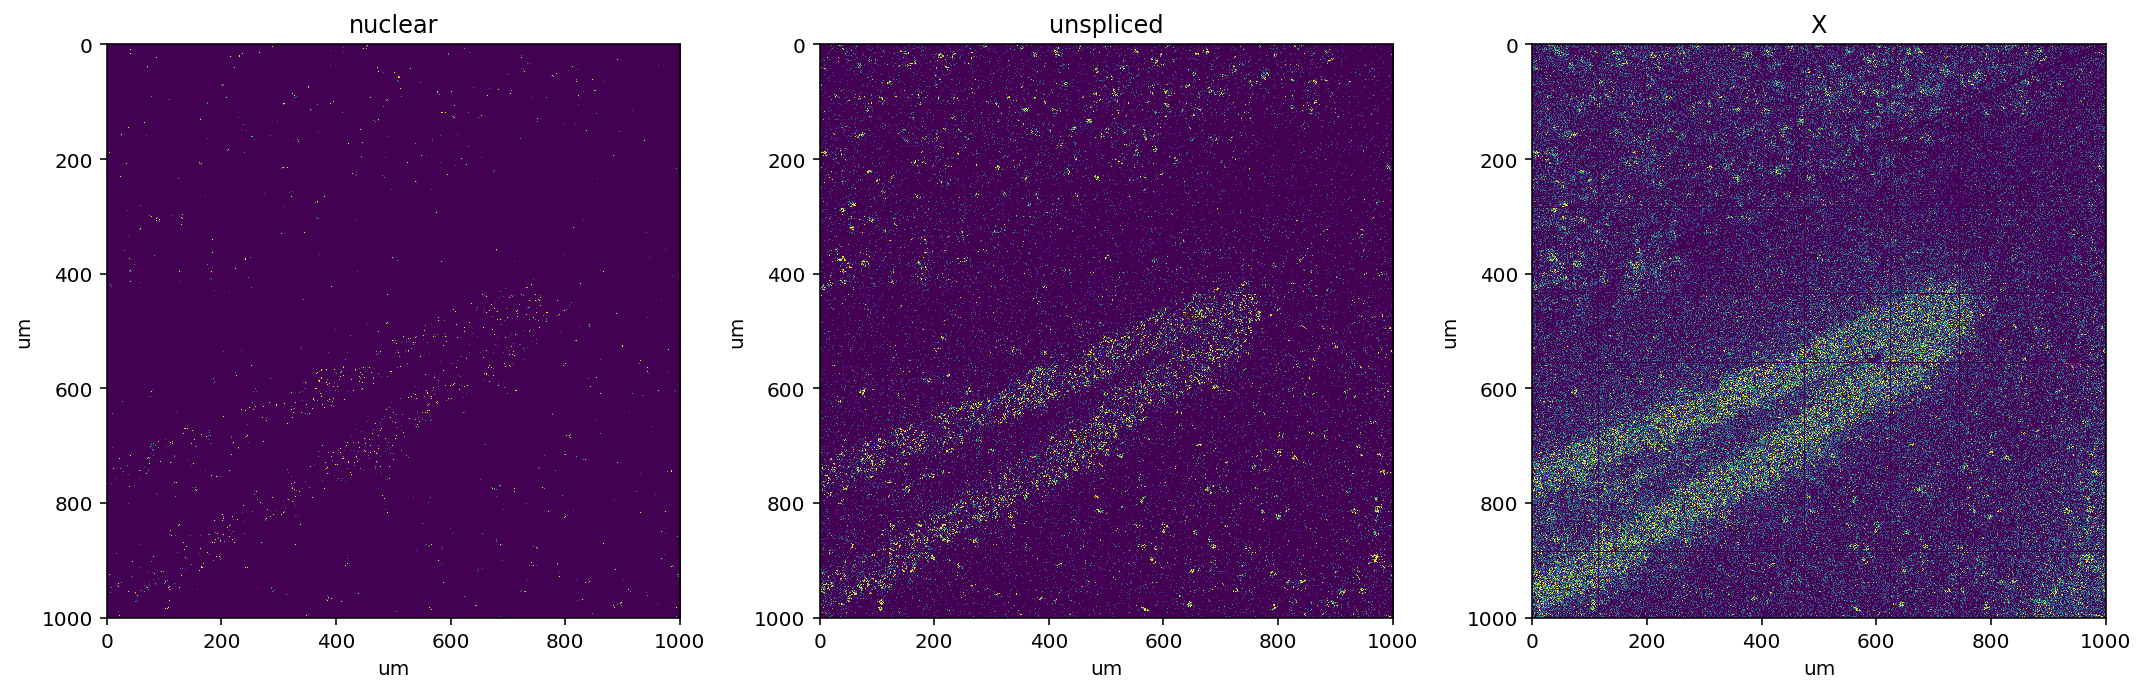

In [68]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclear', ax=axes[0], vmax=3)
st.pl.imshow(adata, 'unspliced', ax=axes[1], vmax=5)
st.pl.imshow(adata, 'X', ax=axes[2], vmax=10)

### 3.1. Identify nuclei with `Malat1`

In [140]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'nuclear', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.001, n_threads=8, seed=0),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3), mk=3
)
st.pp.segmentation.label_connected_components(adata, 'nuclear')

|-----> <select> nuclear layer in AnnData Object
|-----> Scoring pixels with EM+BP method.


Running EM:   0%|                                                                                                      | 0/1 [00:00<?, ?it/s]/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
parallel.py (366): The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Us

|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.48112670791470524.
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


Eroding: 14it [00:00, 169.53it/s]


|-----> <insert> nuclear_labels to layers in AnnData Object.


|-----> <select> nuclear layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object


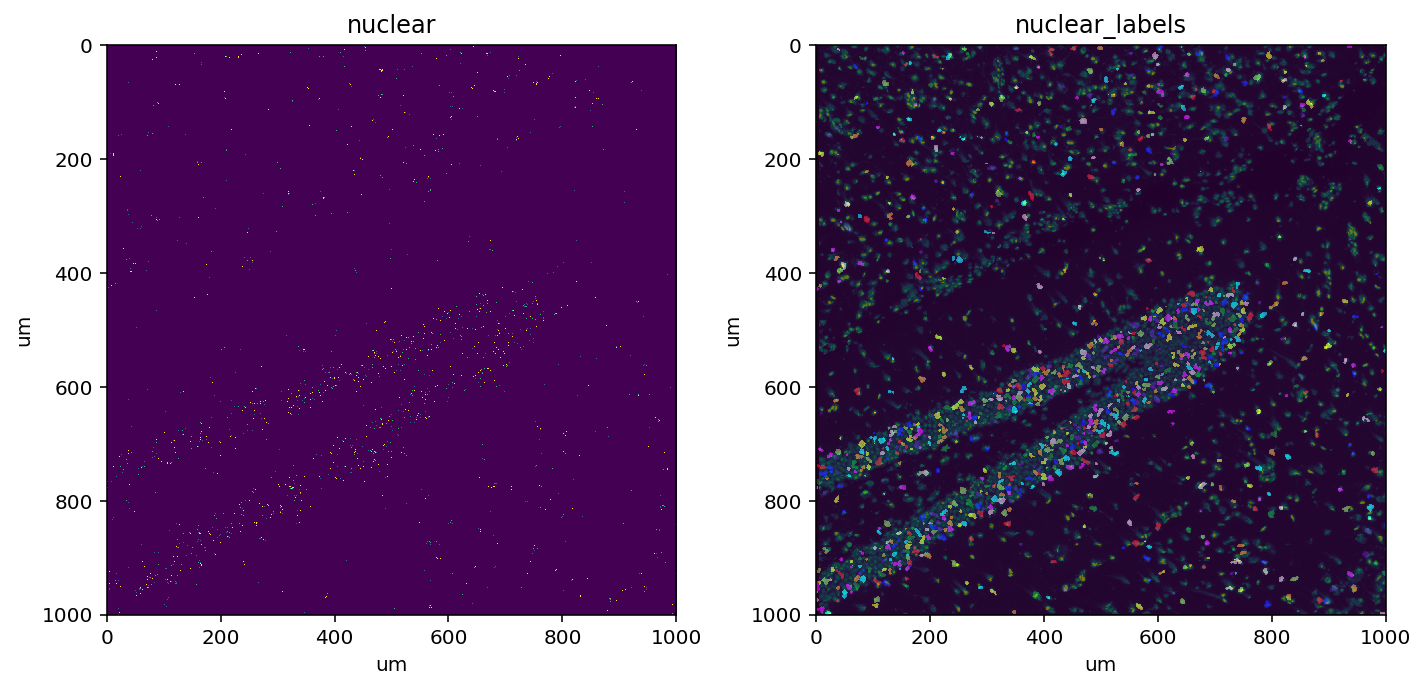

In [141]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclear', ax=axes[0], vmax=3)
st.pl.imshow(adata, 'stain', ax=axes[1])
st.pl.imshow(adata, 'nuclear_labels', labels=True, alpha=0.5, ax=axes[1])

### 3.2. Identify nuclei with unspliced RNA

As we can observe above, the expression/capture of the `Malat1` gene is quite sparse, so it is not necessary to separate out the segmentation to regions with different RNA density. However, the expression/capture of unspliced RNA is much higher and usually requires separating the image into several density regions, and then running segmentation on each region separately. Otherwise, the algorithm is likely to be mis-calibrated and be too sensitive in RNA-rich regions and too strict in RNA-sparse regions.

We recommend first starting off with a lenient (a.k.a. split the pixels into many RNA density regions) and then merging regions manually.

**TODO: add link to technical details page in documentation**

<div class="alert alert-info">
Important
    
Each sample will have a different set of parameters that work well. Selecting the right parameters is usually a subjective trial-and-error process. See [TODO: add link to function API] for descriptions of each of the parameters.
    
</div>

|-----> <select> unspliced layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> unspliced_bins to layers in AnnData Object.
|-----> <select> unspliced_bins layer in AnnData Object


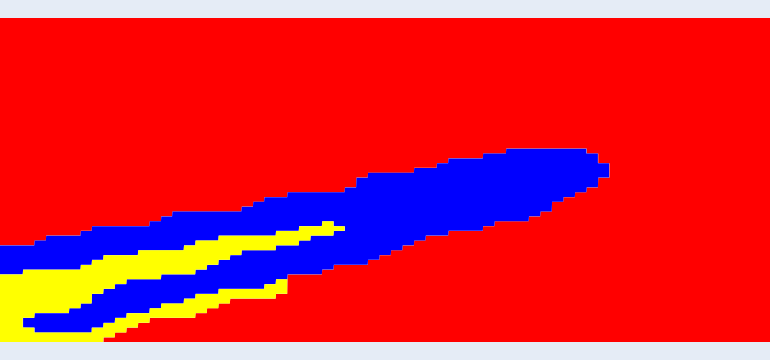

In [52]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 30, k=5, dk=3, distance_threshold=1, background=False)
st.pl.contours(adata, 'unspliced_bins', scale=0.15)

Comparing the above interactive RNA density plot with the unspliced RNA counts we plotted previously, the density in region 3 seems close enough (subjectively) to region 1, so we will merge those.

In [54]:
st.pp.segmentation.merge_densities(adata, 'unspliced_bins', {3: 1})

|-----> <select> unspliced_bins layer in AnnData Object
|-----> Merging densities with mapping {3: 1}.
|-----> <insert> unspliced_bins to layers in AnnData Object.


|-----> <select> unspliced_bins layer in AnnData Object


(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_bins'}, xlabel='um', ylabel='um'>)

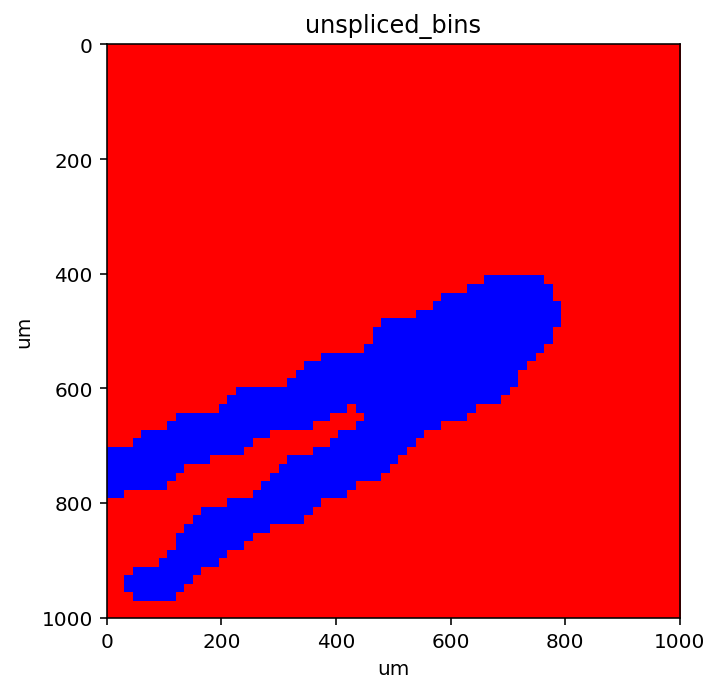

In [55]:
st.pl.imshow(adata, 'unspliced_bins', labels=True)

Then, as we did previously for the nuclear gene counts, identify nuclei using unspliced RNA. Note that the function will automatically detect the RNA density bins and adjust the algorithm accordingly. Also, note that we provide the `certain_layer` argument to `st.pp.segmentation.score_and_mask_pixels` and the `seed_layer` argument to `st.pp.segmentation.label_connected_components` to indicate the nuclei labels obtained from `Malat1`. Internally, these labels are used to further aid the identification of real nuclei.

In [142]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.001, n_threads=8, seed=0),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3),
    certain_layer='nuclear_labels'
)
st.pp.segmentation.label_connected_components(adata, 'unspliced', seed_layer='nuclear_labels')

|-----> <select> unspliced layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object
|-----> <select> unspliced_bins layer in AnnData Object
|-----> Scoring pixels with EM+BP method.


Running EM:   0%|                                                                                                      | 0/3 [00:00<?, ?it/s]/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
parallel.py (366

|-----> <insert> unspliced_scores to layers in AnnData Object.
|-----> Applying threshold 0.4863296968848029.
|-----> <insert> unspliced_mask to layers in AnnData Object.
|-----> <select> unspliced_mask layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object


Eroding: 14it [00:00, 186.84it/s]


|-----> <insert> unspliced_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object


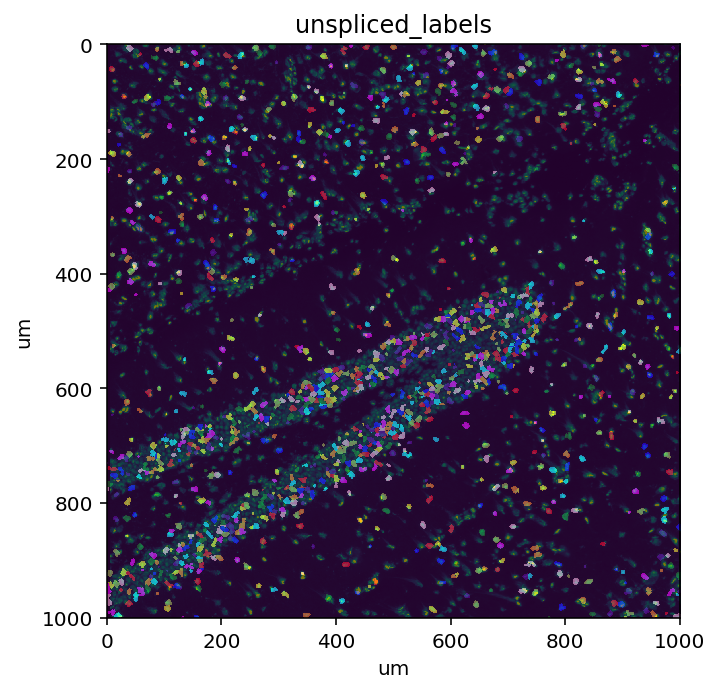

In [143]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'unspliced_labels', labels=True, alpha=0.5, ax=ax)

### 3.3. Expand labels to cytoplasm

Similar to the [2.4 Expand labels to cytoplasm](2.4-Expand-labels-to-cytoplasm) section, we have the option to expand the RNA-based nuclei labels to the cytoplasm. Unlike when a staining image is available, however, we can use the total RNA counts directly to estimate cytoplasmic regions.

Just like how we identified nuclei using unspliced RNA, we first segment the pixels into RNA density regions.

|-----> <select> X layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> X_bins to layers in AnnData Object.
|-----> <select> X_bins layer in AnnData Object


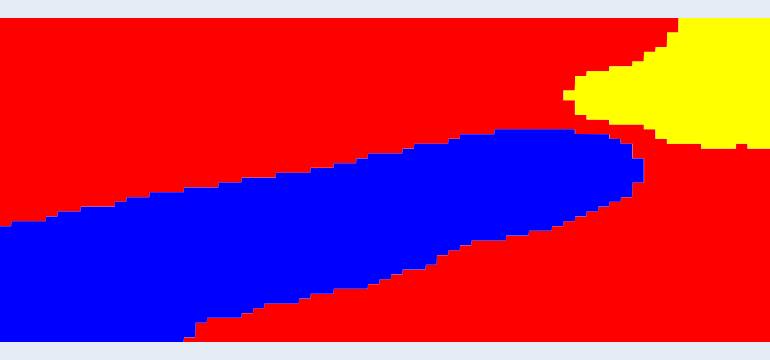

In [151]:
st.pp.segmentation.segment_densities(adata, 'X', 30, k=3, distance_threshold=3, dk=11, background=False)
st.pl.contours(adata, 'X_bins', scale=0.15)

In [152]:
st.pp.segmentation.merge_densities(adata, 'X_bins', {4: 1})

|-----> <select> X_bins layer in AnnData Object
|-----> Merging densities with mapping {4: 1}.
|-----> <insert> X_bins to layers in AnnData Object.


|-----> <select> X_bins layer in AnnData Object


(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'X_bins'}, xlabel='um', ylabel='um'>)

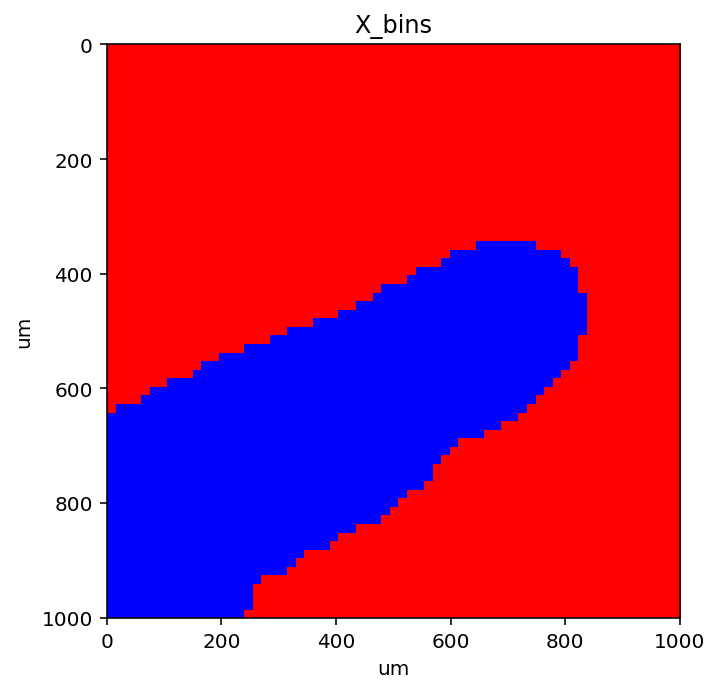

In [153]:
st.pl.imshow(adata, 'X_bins', labels=True)

Then, we take a very similar approach once again to identify cytoplasmic regions, but instead of using `st.pp.segmentation.label_connected_components` to obtain the labels, we will simply expand the nuclei labels up to a specified maximum area, restricting the expansion to within the identified cytoplasmic regions.

In [156]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=15, method='EM+BP',
    em_kwargs=dict(downsample=0.001, n_threads=8, seed=0),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3),
    certain_layer='unspliced_labels'
)
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=400, mask_layer='X_mask', out_layer='X_labels'
)

|-----> <select> X layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object
|-----> <select> X_bins layer in AnnData Object
|-----> Scoring pixels with EM+BP method.


Running EM:   0%|                                                                                                      | 0/2 [00:00<?, ?it/s]/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
Running EM:  50%|###############################################                                               | 1/2 [00:03<00:03,  3.61s/it]parallel.py (366): The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
network.py (36): The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a fir

|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.4941442288693789.
|-----> <insert> X_mask to layers in AnnData Object.
|-----> <select> unspliced_labels layer in AnnData Object
|-----> Expanding labels.
|-----> <insert> X_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> X_labels layer in AnnData Object


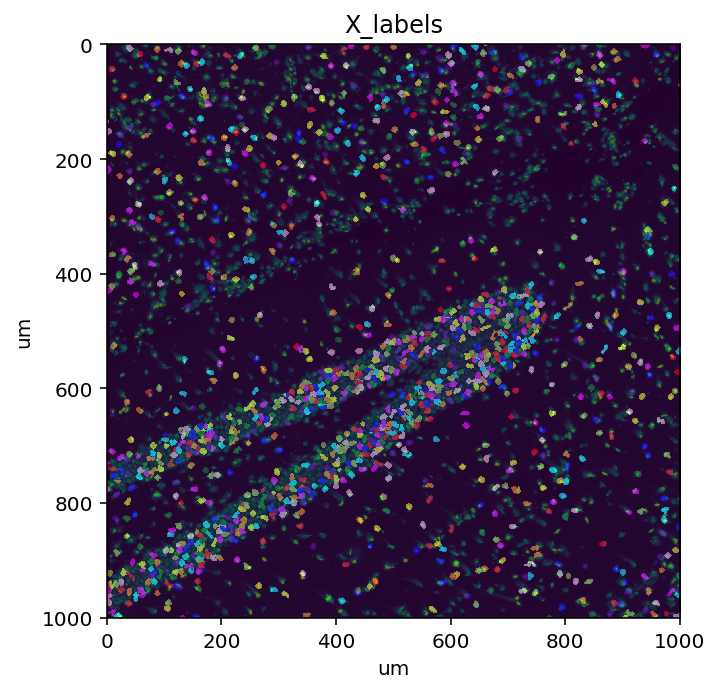

In [157]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'X_labels', labels=True, alpha=0.5, ax=ax)

## 4. Getting a cell x gene matrix

Finally, we will use our segmentation results to obtain the desired cell-by-gene counts matrix. For this part, we will only be using the final labels obtained from nuclei staining (saved in the `cell_labels` layer), but the same can be done for the RNA-based labels.

But first, we will expand all the cell labels by some amount to mitigate the effects of RNA diffusion. The distance that should be expanded will depend on the level of RNA diffusion in the data.

In [166]:
st.pp.segmentation.expand_labels(
    adata, 'cell_labels', distance=2, out_layer='cell_labels_expanded'
)

|-----> <select> cell_labels layer in AnnData Object
|-----> Expanding labels.
|-----> <insert> cell_labels_expanded to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels_expanded layer in AnnData Object


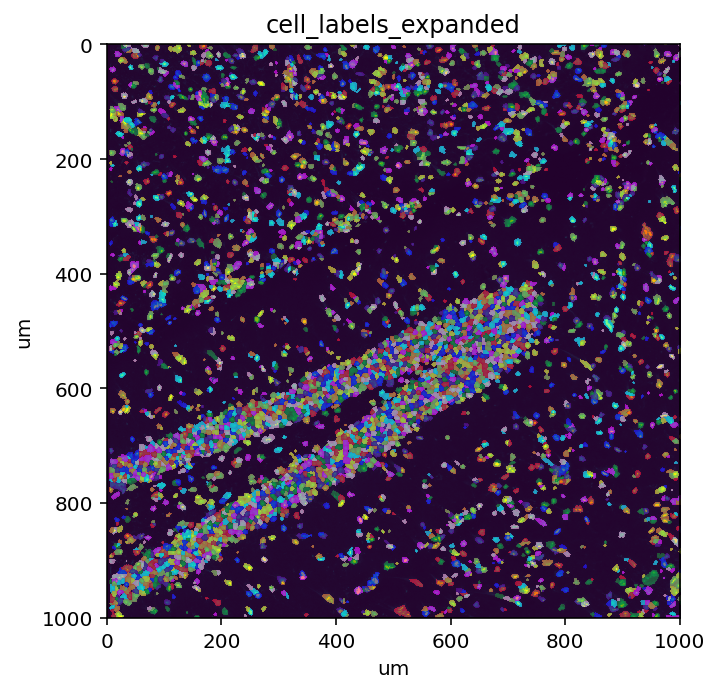

In [170]:
fig, ax = st.pl.imshow(adata, 'stain')
st.pl.imshow(adata, 'cell_labels_expanded', labels=True, alpha=0.5, ax=ax)

In [169]:
cell_adata = st.io.read_bgi(
    'SS200000135TL_D1_all_bin1.txt.gz',
    segmentation_adata=adata,
    labels_layer='cell_labels_expanded',
    scale=0.5, scale_unit='um', 
)
cell_adata

|-----> <select> cell_labels_expanded layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 4351 × 19815
    obs: 'area'
    uns: '__type', 'pp', 'spatial'
    obsm: 'spatial', 'contour', 'bbox'
    layers: 'spliced', 'unspliced'